In [519]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_mas.common.orthotopes.base import batch_create_hypercube
from torch_mas.common.models.linear_models import batch_predict_linear_regression

In [520]:
import matplotlib.patches as patches
from scipy.interpolate import griddata

def plot_hypercubes(ax, hypercubes: torch.Tensor, color="C0", alpha=0.4):
    for h in hypercubes:
        low, high = h[:, 0], h[:, 1]
        side_lengths = high - low

        patch = patches.Rectangle(low, side_lengths[0], side_lengths[1], facecolor=color, alpha=alpha)
        ax.add_patch(patch)

def plot_as_heatmap(ax, x, y, z, n_points=1000, cmap="viridis", norm=None, interpolation="linear"):
    x_min, x_max = min(x), max(x)
    y_min, y_max = min(y), max(y)
    X, Y = np.meshgrid(np.linspace(x_min, x_max, n_points), np.linspace(y_min, y_max, n_points))
    Z = griddata((x, y), z, (X, Y), method=interpolation)
    pcm = ax.imshow(Z, extent=[x_min, x_max, y_min, y_max], origin="lower", cmap=cmap, norm=norm)
    return pcm

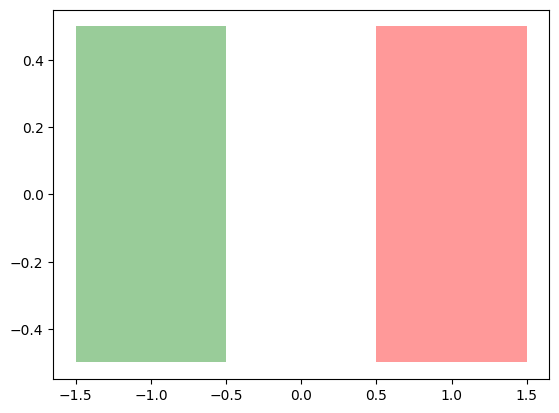

In [521]:
side_lengths = torch.as_tensor([1.0, 1.0])
x1 = torch.as_tensor([-1, 0])
x2 = torch.as_tensor([1, 0])

X = torch.vstack([x1, x2])
H = batch_create_hypercube(X, side_lengths)

ax = plt.gca()
plt.scatter(X[:, 0], X[:, 1], alpha=0)
plot_hypercubes(ax, [H[0]], color="g")
plot_hypercubes(ax, [H[1]], color="r")

torch.Size([100, 2]) torch.Size([2, 2]) torch.Size([1, 100, 2])


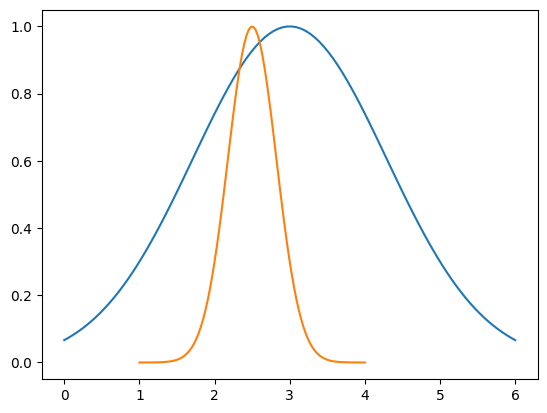

In [522]:
def dim_activated(x: torch.Tensor, h: torch.Tensor, limit_probability: torch.Tensor):
    """Return activation for one dimension of one point for one hyperrectangle

    Args:
        x (torch.Tensor): (batch_size, in_dims)
        h (torch.Tensor): (in_dims, 2)
        limit_probability (float, optional): probability reached on limits of hyperrectangle. Defaults to 0.3.

    Returns:
        torch.Tensor: (batch_size, in_dims)
    """
    low, high = h[:, 0], h[:, 1]
    mu = (high + low) / 2
    sigma = torch.sqrt(-(high-mu)**2/(2*torch.log(limit_probability)))
    return torch.exp(-(x-mu)**2/(2*sigma**2))

batch_dim_activated = torch.vmap(dim_activated, in_dims=(None, 0, None)) # batch over hyperrectangles

h1 = torch.as_tensor([[1, 5], [2, 3]])
x = torch.stack([torch.linspace(0, 6, 100), torch.linspace(1, 4, 100)]).T
# a = dim_activated(x, h1, torch.as_tensor(0.3))
a = batch_dim_activated(x, h1.unsqueeze(0), torch.as_tensor(0.3))
print(x.shape, h1.shape, a.shape)

plt.plot(x, a[0])
plt.show()

torch.Size([10000, 2]) torch.Size([2, 2]) torch.Size([1, 10000])


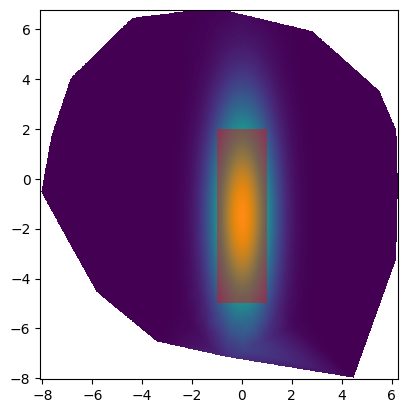

In [523]:
def activated(x: torch.Tensor, h: torch.Tensor, limit_probability: torch.Tensor):
    """_summary_

    Args:
        x (torch.Tensor): (x_batch_size, in_dims)
        h (torch.Tensor): (h_batch_size, in_dims, 2)
        limit_probability (float, optional): probability reached on limits of hyperrectangle. Defaults to 0.3.

    Returns:
        torch.Tensor: (x_batch_size)
    """
    a = batch_dim_activated(x, h, torch.as_tensor(limit_probability)) # activation for each individual dimension
    return torch.prod(a, dim=-1)
    
n = 10000
h1 = torch.as_tensor([[-1, 1], [-5, 2]])
# x = torch.stack([torch.linspace(0, 6, 100), torch.linspace(1, 4, 100)]).T
x = torch.randn((n, 2))*2
a = activated(x, h1.unsqueeze(0), torch.as_tensor(0.5))
print(x.shape, h1.shape, a.shape)

ax = plt.gca()
plot_as_heatmap(ax, x[:, 0], x[:, 1], a[0])
plot_hypercubes(ax, h1.unsqueeze(0), color="r")

## Visualization of Activation

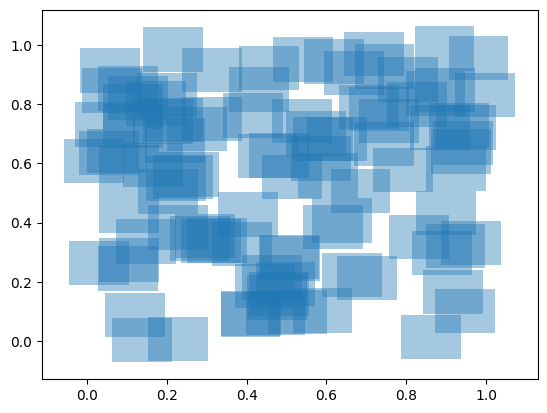

In [524]:
n_agents = 100

# random agents initialization
side_lengths = torch.ones(n_agents)*0.15
centers = torch.rand((n_agents, 2))
orthotopes = batch_create_hypercube(centers, side_lengths)

ax = plt.gca()
ax.scatter(centers[:, 0], centers[:, 1], alpha=0)
plot_hypercubes(ax, orthotopes)

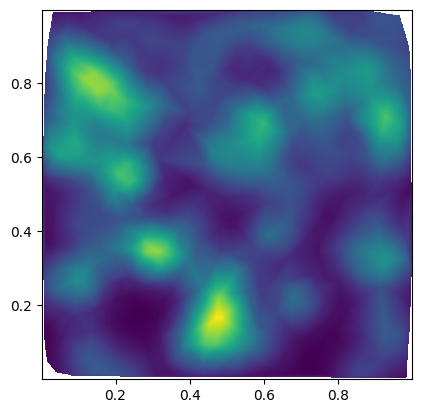

In [525]:
n = 1000
X = torch.rand((n, 2))
activations = activated(X, orthotopes, 0.3).mean(0)
ax = plt.gca()
plot_as_heatmap(ax, X[:, 0], X[:, 1], activations)

## Learning

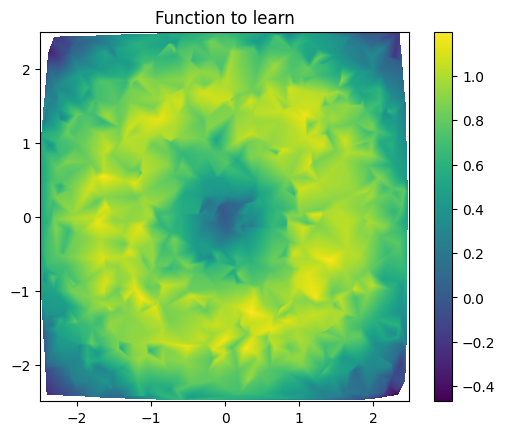

In [526]:
from torch.utils.data import TensorDataset, DataLoader

device = "cpu"

num_samples = 1000
test_size = 1000
num_features = 2
noise_level = 0.1
X = (torch.rand(num_samples, num_features)-0.5)*5
y = (torch.sin(torch.sqrt(X[:, 0]**2 + X[:, 1]**2)) + torch.randn(X.size(0))*noise_level).unsqueeze(-1)
X_test = (torch.rand(num_samples, num_features)-0.5)*5
y_test = (torch.sin(torch.sqrt(X_test[:, 0]**2 + X_test[:, 1]**2))).unsqueeze(-1)
train_dataset = TensorDataset(X, y)

X.shape, y.shape

fig = plt.gcf()
ax = plt.gca()
# pcm = plot_as_heatmap(ax, X_test[:, 0], X_test[:, 1], y_test)
pcm = plot_as_heatmap(ax, X[:, 0], X[:, 1], y)
ax.set_title("Function to learn")
fig.colorbar(pcm)

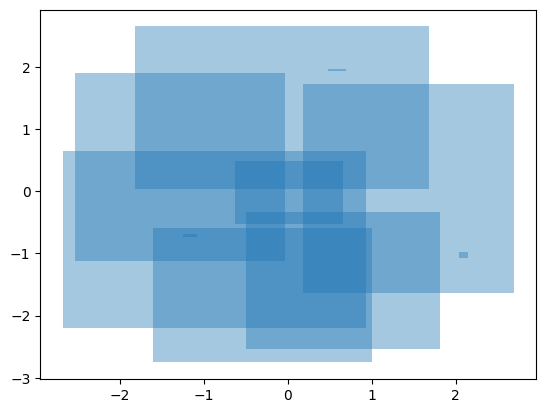

In [533]:
n_agents = 10
input_dim = 2
output_dim = 1
lr = 1e-2
batch_size = 16
n_epochs = 20
limit_probability = 0.3

# random agents initialization
side_lengths = torch.ones(n_agents)*0.3
centers = torch.rand((n_agents, 2))*4-2
# plt.plot(centers[:, 0], centers[:, 1], "ro")
# plt.plot(centers[:, 0], centers[:, 1])
orthotopes:torch.Tensor = batch_create_hypercube(centers, side_lengths)
orthotopes.requires_grad_()
parameters = torch.randn(
            n_agents,
            input_dim + 1,
            output_dim,
            dtype=torch.float,
            requires_grad=True,
        )  # (n_agents, input_dim+1, output_dim) Tensor of linear models

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

optimizer = torch.optim.Adam([orthotopes, parameters], lr=lr)

parameters_hist = [parameters.detach().clone()]
orthotopes_hist = [orthotopes.detach().clone()]

_step = 0
for e in range(n_epochs):
    # training loop
    # 1: activations
    # 2: predictions
    # 3: loss => mse_loss
    # 4: update
    for b_X, b_y in train_dataloader:
        activations = activated(b_X, orthotopes, limit_probability).unsqueeze(-1)
        predictions = torch.mean(batch_predict_linear_regression(b_X, parameters) * activations, dim=0)
        loss = torch.nn.functional.mse_loss(predictions, b_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        parameters_hist += [parameters.detach().clone()]
        orthotopes_hist += [orthotopes.detach().clone()]

    _step += 1

    activations = activated(X, orthotopes, limit_probability).unsqueeze(-1)
    predictions = torch.mean(batch_predict_linear_regression(X, parameters) * activations, dim=0).detach()
    ax = plt.gca()
    plot_as_heatmap(ax, X[:, 0], X[:, 1], predictions)
    plt.savefig(f"tmp/pred/pred_{_step:05}.png")
    plt.cla()
    plt.clf()

    ax = plt.gca()
    ax.scatter(X[:, 0], X[:, 1], alpha=0)
    plot_hypercubes(ax, orthotopes.detach())
    plt.savefig(f"tmp/orthotopes/ortho_{_step:05}.png")
    plt.cla()
    plt.clf()


ax = plt.gca()
ax.scatter(centers[:, 0], centers[:, 1], alpha=0)
plot_hypercubes(ax, orthotopes.detach())

torch.Size([1000, 1])
torch.Size([1000, 1]) torch.Size([1000, 2])


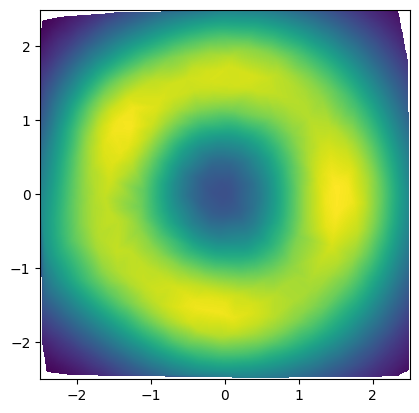

In [496]:
activations = activated(X, orthotopes, limit_probability).unsqueeze(-1).detach()
y = torch.mean(batch_predict_linear_regression(X, parameters) * activations, dim=0).detach()
print(y.shape)
print(y.shape, X.shape)
ax = plt.gca()
plot_as_heatmap(ax, X[:, 0], X[:, 1], y)

torch.Size([1000, 2]) torch.Size([1000])


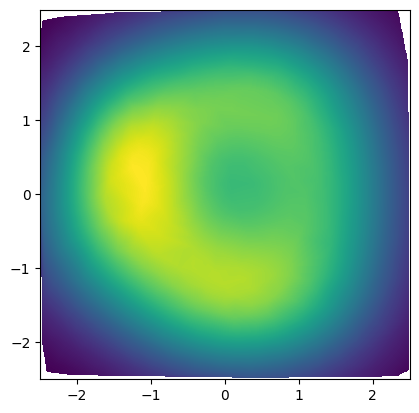

In [ ]:
ax = plt.gca()
activations = activated(X, orthotopes, limit_probability).sum(dim=0).detach()
print(X.shape, activations.shape)
plot_as_heatmap(ax, X[:, 0], X[:, 1], activations, )

## Animations

In [498]:
from manim import *
import tqdm

In [502]:
class Animate(Scene):
    def construct(self):
        self.camera.background_color = WHITE
        title = Text("Context Agent Spatial Organization during Learning", font_size=32, color=BLACK)

        title.to_edge(UP)
        title.shift(3.3 * UP)
        self.play(Write(title), run_time=0.5)

        rectangles = []
        for i in tqdm.tqdm(range(0, len(orthotopes_hist)-1, 100)):
            hist = orthotopes_hist[1:][i]
            orthotopes = np.array(hist)

            update_anims = []
            for idx, rect in enumerate(rectangles):
                h = orthotopes[idx]
                low, high = h[:, 0], h[:, 1]
                side_lengths = high - low
                new_rect = Rectangle(
                    BLUE, 
                    stroke_width=0, 
                    fill_opacity=0.3, 
                    width=side_lengths[0], 
                    height=side_lengths[1]
                ).move_to([(high[0] + low[0])/2, (high[1] + low[1])/2, 0])
                update_anims += [Transform(rect, new_rect)]
                rect = new_rect

            l = len(rectangles)
            create_anims = []
            for h in orthotopes[l:]:
                low, high = h[:, 0], h[:, 1]
                side_lengths = high - low
                rect = Rectangle(
                    RED,
                    stroke_width=0,
                    fill_opacity=0.3,
                    width=side_lengths[0],
                    height=side_lengths[1]
                ).move_to([(high[0] + low[0])/2, (high[1] + low[1])/2, 0])
                rectangles += [rect]
                create_anims += [Create(rect)]

            if len(update_anims) > 0:
                self.play(*update_anims, run_time=0.2)
            if len(create_anims) > 0:
                self.play(*create_anims, run_time=0.2)

# %manim -o output.mp4 -r 720,720 -qm -v WARNING Animate
%manim -o output.mp4 -r 1200,720 -qm -v WARNING Animate

Manim Community v0.18.1

100%|██████████| 13/13 [00:03<00:00,  3.28it/s]                                                                      


In [ ]:
from manim import *
import numpy as np
from scipy.interpolate import griddata

class SurfaceEvolutionAnimation(ThreeDScene):
    def __init__(self, **kwargs):
        """
        Parameters:
        data_history: List of dictionaries, each containing:
            'x': array of x coordinates
            'y': array of y coordinates
            'z': array of z values
        """
        super().__init__(**kwargs)
        self.data_history = data_history

    def interpolate_surface(self, x, y, z):
        # Create a regular grid to interpolate the data
        x_grid = np.linspace(min(x), max(x), 50)
        y_grid = np.linspace(min(y), max(y), 50)
        X, Y = np.meshgrid(x_grid, y_grid)
        
        # Interpolate scattered data to regular grid
        Z = griddata((x, y), z, (X, Y), method='cubic', fill_value=np.nan)
        return X, Y, Z

    def construct(self):
        # Set up the scene
        self.set_camera_orientation(phi=75 * DEGREES, theta=30 * DEGREES)
        axes = ThreeDAxes()
        self.add(axes)

        # Create the initial surface
        x0, y0, z0 = self.data_history[0]['x'], self.data_history[0]['y'], self.data_history[0]['z']
        X, Y, Z = self.interpolate_surface(x0, y0, z0)
        
        surface = Surface(
            lambda u, v: np.array([
                X[int(u * (X.shape[0]-1)), int(v * (X.shape[1]-1))],
                Y[int(u * (Y.shape[0]-1)), int(v * (Y.shape[1]-1))],
                Z[int(u * (Z.shape[0]-1)), int(v * (Z.shape[1]-1))]
            ]),
            u_range=[0, 1],
            v_range=[0, 1],
            resolution=(50, 50)
        )
        
        surface.set_style(
            fill_opacity=0.8,
            stroke_color=WHITE,
            stroke_width=0.5,
            fill_color=BLUE
        )
        self.add(surface)

        # Animate surface evolution
        for frame_data in self.data_history[1:]:
            x, y, z = frame_data['x'], frame_data['y'], frame_data['z']
            X_new, Y_new, Z_new = self.interpolate_surface(x, y, z)
            
            new_surface = Surface(
                lambda u, v: np.array([
                    X_new[int(u * (X_new.shape[0]-1)), int(v * (X_new.shape[1]-1))],
                    Y_new[int(u * (Y_new.shape[0]-1)), int(v * (Y_new.shape[1]-1))],
                    Z_new[int(u * (Z_new.shape[0]-1)), int(v * (Z_new.shape[1]-1))]
                ]),
                u_range=[0, 1],
                v_range=[0, 1],
                resolution=(50, 50)
            )
            
            new_surface.set_style(
                fill_opacity=0.8,
                stroke_color=WHITE,
                stroke_width=0.5,
                fill_color=BLUE
            )
            
            self.play(
                Transform(surface, new_surface),
                run_time=1
            )
            self.wait(0.5)

# Example data format:
data_history = [
    {
        'x': np.array([0, 1, 2, 0, 1, 2, 0, 1, 2]),
        'y': np.array([0, 0, 0, 1, 1, 1, 2, 2, 2]),
        'z': np.array([0, 1, 0, 1, 2, 1, 0, 1, 0])
    },
    {
        'x': np.array([0, 1, 2, 0, 1, 2, 0, 1, 2]),
        'y': np.array([0, 0, 0, 1, 1, 1, 2, 2, 2]),
        'z': np.array([1, 2, 1, 2, 3, 2, 1, 2, 1])
    }
    # Add more frames as needed
]

# Example usage:
def create_animation():
    scene = SurfaceEvolutionAnimation()
    scene.render()


        
%manim -o output.mp4 -r 1200,720 -qm -v WARNING SurfaceEvolutionAnimation

Manim Community v0.18.1